In [1]:
import sys
import os
from scipy.io import wavfile
import numpy as np
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
%load_ext rpy2.ipython

In [5]:
#os.environ["DATA_DIR"] = "/Volumes/CB_RESEARCH/vocal_synthesis/"

In [6]:
data_folder = os.environ["DATA_DIR"]
with open(data_folder + os.path.sep + "x1_50_all_use_mean.pkl") as f:
    dat = pickle.load(f)
X_train, X_valid, X_test = dat[0]
X_train.shape, X_valid.shape, X_test.shape

((174, 50, 16000), (21, 50, 16000), (21, 50, 16000))

In [7]:
args = dict()
args["seed"] = 0
args["batch_size"] = 16
args["learning_rate"] = 0.01
args["momentum"] = 0.9
args["num_epochs"] = 2000
args["X_train"] = X_train
args["X_valid"] = X_valid
args["X_test"] = X_test
args["update_method"] = rmsprop

args["config"] = "../configurations/19feb_testing_d_minimalist1.py"

In [8]:
sys.path.append("..")
import rnn_experiment as exp
symbols = exp.prepare(args)
out_fn = symbols["out_fn"]
l_out = symbols["l_out"]
with open(data_folder + os.path.sep + "expensive_models" + os.path.sep + "16mar_minimalist1_use_mean.model") as f:
    model = pickle.load(f)
set_all_param_values(l_out, model)

loading config: ../configurations/19feb_testing_d_minimalist1.py
Number of params in model: 25824100


In [61]:
X_test.shape

(21, 50, 16000)

In [113]:
generated_seq = X_valid[0:1].flatten().tolist()
prev_seq_chunk = X_valid[0:1]
#prev_seq_chunk += np.random.normal(0, 0.01, size=prev_seq_chunk.shape)
for x in range(0, 50):
    next_seq_chunk = out_fn(prev_seq_chunk) # x2, ..., x1001
    generated_seq += next_seq_chunk[0][-1].flatten().tolist() # append x1001 to end
    prev_seq_chunk = next_seq_chunk
# np.random.normal(0, 100, size=next_seq_chunk.shape)

In [109]:
float(len(generated_seq)) / 16000.0

100.0

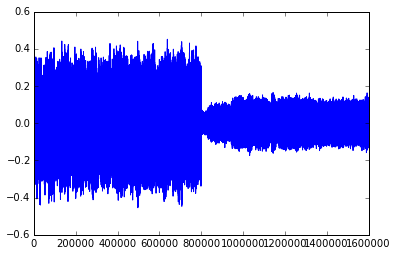

In [110]:
plt.plot(generated_seq)
plt.show()

In [12]:
fs, data = wavfile.read(data_folder + os.path.sep + "data.wav")
print data.dtype
data = np.asarray(data, dtype="float32")
min_, max_, mean_ = np.min(data), np.max(data), np.mean(data)

int16


In [114]:
tmp = np.asarray(generated_seq)
tmp = (tmp * (max_ - min_)) + mean_
tmp = np.asarray(tmp, dtype="int16")

In [116]:
out_file = "/tmp/t200.wav"
#os.remove(out_file)
wavfile.write(filename=out_file, rate=fs, data=tmp[0:(50*fs)])

In [59]:
os.remove

<function posix.remove>

In [26]:
np.min(tmp), np.max(tmp), np.mean(tmp)

(-8356.0002385415137, 8128.0000556670129, 0.49593937992075698)

In [27]:
min_, max_, mean_

(-8936.0, 9124.0, 0.047603961)

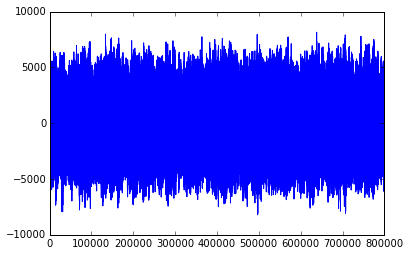

In [117]:
plt.plot(wavfile.read("/tmp/t100.wav")[1])

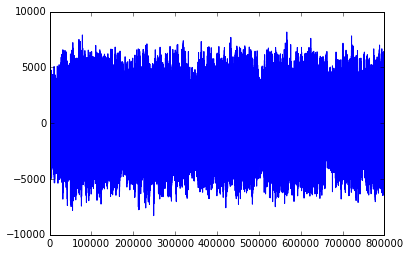

In [118]:
plt.plot(wavfile.read("/tmp/t200.wav")[1])

----

Let's look at the learning curves.

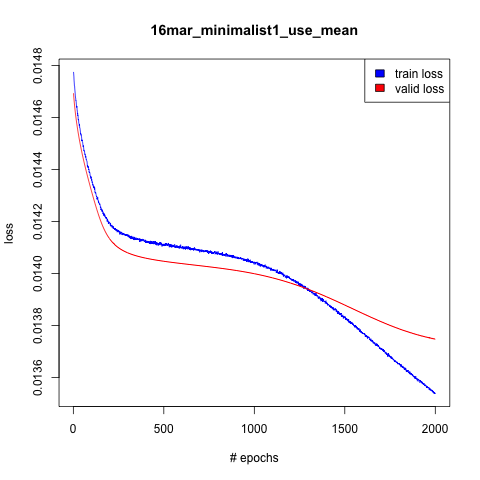

In [120]:
%%R
df = read.csv("../models/16mar_minimalist1_use_mean.txt")
plot(df$train_loss, type="l", xlab="# epochs", ylab="loss", col="blue", main="16mar_minimalist1_use_mean")
lines(df$valid_loss, type="l", col="red")
legend("topright", legend=c("train loss", "valid loss"), fill=c("blue", "red"))

How long did training take (in minutes)?

In [121]:
%%R
sum(df$duration) / 60.0

[1] 90.22539
